In [543]:
import casadi as ca
import numpy as np
import pandas as pd
from pytope import Polytope
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [544]:
nu = 2
N_Sam = 20
n_generator = 2

random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)

[[-0.72075172  0.83584482  0.50195917  0.14826556 -0.7066584  -0.63070084
  -0.32630765  0.78607445 -0.25304736  0.55560434 -0.05226919 -0.38953636
   0.81650966  0.36444441  0.5204217  -0.9163145  -0.97028136 -0.98895859
   0.26742401 -0.94772516]
 [ 0.16937548 -0.74578421 -0.73905638 -0.56903589 -0.91821796  0.08825358
   0.09669043 -0.44912501 -0.15887661  0.61999318 -0.61707447  0.17473337
  -0.80460408 -0.23846831 -0.56590365 -0.36148872 -0.26680532 -0.18733213
   0.73127471  0.45661447]]


In [545]:
data_id = "08"
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 27]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
print(random_vals.shape)
N_Sam = random_vals.shape[1]


(2, 1390)


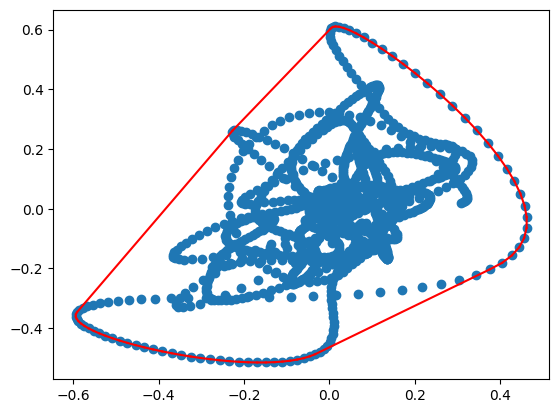

Convex Hull Points (2xN):
 [[-0.22666 -0.59141 -0.59407 -0.59433 -0.59233 -0.58818 -0.58199 -0.57389
  -0.56399 -0.5524  -0.53925 -0.52466 -0.50873 -0.49159 -0.47336 -0.45415
  -0.43408 -0.41327 -0.39184 -0.36989 -0.34756 -0.32496 -0.3022  -0.2794
  -0.25669 -0.23417 -0.21197 -0.1902  -0.16898 -0.14843 -0.12866 -0.1098
  -0.09196 -0.07525 -0.0598  -0.04572 -0.03314  0.37657  0.40514  0.42819
   0.44546  0.45689  0.46258  0.46275  0.45775  0.44801  0.43402  0.41623
   0.39516  0.37134  0.3453   0.31759  0.28874  0.25933  0.22996  0.2012
   0.17353  0.14734  0.12294  0.10057  0.0804   0.06253  0.04702  0.03386
   0.02302  0.01444  0.00802  0.00367]
 [ 0.26175 -0.34642 -0.35352 -0.36092 -0.36856 -0.37641 -0.38442 -0.39256
  -0.40076 -0.40901 -0.41724 -0.42542 -0.43351 -0.44145 -0.44922 -0.45676
  -0.46404 -0.471   -0.47761 -0.48383 -0.4896  -0.49489 -0.49966 -0.50386
  -0.50745 -0.51038 -0.51261 -0.51411 -0.51482 -0.5147  -0.51372 -0.51182
  -0.50897 -0.50511 -0.50022 -0.49424 -0.48714 -0

In [546]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Example set of points (shape: 2x30)
points = random_vals

# Reshape to (30, 2) so ConvexHull can process it
points = points.T  # Transpose to make it (30, 2)

# Compute the convex hull
hull = ConvexHull(points)

# Plot the points and the convex hull
plt.scatter(points[:, 0], points[:, 1])
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
plt.show()

# Convex hull vertices (in (N, 2) shape)
convex_points = points[hull.vertices]

# Reshape the convex hull points to 2xN
convex_points = convex_points.T  # Transpose back to 2xN shape

print("Convex Hull Points (2xN):\n", convex_points)
N_Convex = convex_points.shape[1]

In [547]:
def opti_zono():
    opti = ca.Opti()

    c = opti.variable(nu,1)
    g = opti.variable(nu,n_generator)
    lam = opti.variable(n_generator,N_Convex)
    lam_bound = opti.variable(n_generator,1)

    samples = opti.parameter(nu,N_Convex)

    opti.minimize(ca.sum1(lam_bound))

    for i in range(N_Convex):
        opti.subject_to(samples[:,i] ==  c + g@lam[:,i])

    for i in range(n_generator):
        for j in range(N_Convex):
            opti.subject_to(lam[i, j] >= -lam_bound[i])
            opti.subject_to(lam[i, j] <= lam_bound[i]) 


    opts = {"ipopt.print_level": 4, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [c, g, lam]) 

In [548]:
pass
# f = opti_zono()
# c_hat, g_hat,lam_hat = f(convex_points)
# print(c_hat, g_hat,lam_hat)

In [549]:
def opti_circle(P):
    center = ca.SX.sym('center', 2)  # (x, y)
    radius = ca.SX.sym('radius') 
    
    constraints = []
    N = P.shape[1]
    for i in range(N):
        p1 = P[:, i]
        p2 = P[:, (i + 1) % N]

        edge = p2 - p1
        normal = np.array([-edge[1], edge[0]]) 
        normal = normal / np.linalg.norm(normal)

        distance = ca.dot(normal, center - p1)

        constraints.append(distance - radius)
    g = ca.vertcat(*constraints)

    objective = -radius 

    nlp = {'x': ca.vertcat(center, radius), 'f': objective, 'g': g}
    solver = ca.nlpsol('solver', 'ipopt', nlp)
    x0 = [np.mean(P[0, :]), np.mean(P[1, :]), 0.1]
    lbx = [-ca.inf, -ca.inf, 0]  # x, y, r >= 0
    ubx = [ca.inf, ca.inf, ca.inf]

    lbg = [0] * N 
    ubg = [ca.inf] * N 

    sol = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)

    optimal_center = np.array(sol['x'][0:2].full()).flatten()
    optimal_radius = float(sol['x'][2])

    return optimal_center,optimal_radius

In [550]:
center, radius = opti_circle(convex_points)
print(convex_points.shape)
rotated_x = -convex_points[0,:]+2*center[0]
rotated_y = -convex_points[1,:]+2*center[1]
rotated_convex_points = np.array([rotated_x,rotated_y])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      204
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       68
        inequality constraints with only lower bounds:       68
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 0.00e+00 9.85e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [551]:
stacked_points = np.hstack((convex_points, rotated_convex_points))

<Figure size 640x480 with 0 Axes>

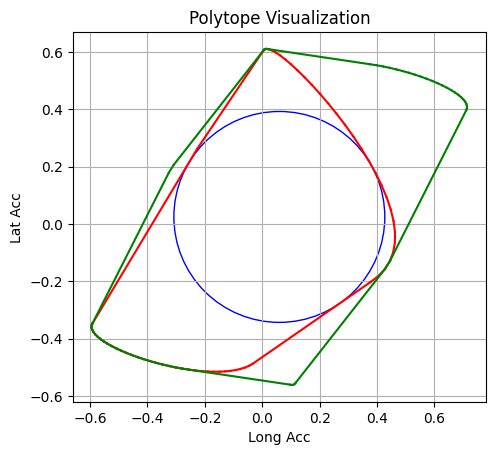

In [552]:
plt.figure()
fig, ax = plt.subplots()
#sample points
#plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')
#plt.scatter(rotated_convex_points[0,:],rotated_convex_points[1,:],marker='x',color = 'blue')

circle = plt.Circle(center, radius, color='blue', fill=False)

# Add the circle to the plot
ax.add_artist(circle)

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

points = stacked_points.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'g-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()